# OpenAI Fine-tuning API 

In [1]:
import re
import pandas as pd 
import numpy as np
import openai 

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
# set the api key
openai.api_key = os.getenv("OPENAI_API_KEY")

In [3]:
############ Notes on formatting for GPT fine-tuning ####################

# - Based on your file extension, your file is formatted as a CSV file
# - Your file contains 56 prompt-completion pairs. In general, we recommend having at least a few hundred examples. We've found that performance tends to linearly increase for every doubling of the number of examples
# - Your data does not contain a common separator at the end of your prompts. Having a separator string appended to the end of the prompt makes it clearer to the fine-tuned model where the completion should begin. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more detail and examples. If you intend to do open-ended generation, then you should leave the prompts empty
# - All completions end with suffix ` `
#   WARNING: Some of your completions contain the suffix ` ` more than once. We suggest that you review your completions and add a unique ending
# - The completion should start with a whitespace character (` `). This tends to produce better results due to the tokenization we use. See https://beta.openai.com/docs/guides/fine-tuning/preparing-your-dataset for more details

# add a space to the end of each prompt
# Each prompt should end with a fixed separator to inform the model when the prompt ends and the completion begins. A simple separator which generally works well is \n\n###\n\n. The separator should not appear elsewhere in any prompt.

# Load local data setup 

In [4]:
## FastAI Q&A pairs 
pc_csv_IN_path = "data/prompt-enhancement-image-generation_prepended.csv"
this_model_name = "prompt-enhancement-image-generation"

test_prompts_path = "tests/image_test_prompts.txt"

assert os.path.exists(pc_csv_IN_path), "File does not exist"

In [5]:
tests_dir_path = "tests/"
tests_output_dir_path = "test-outputs/"

# test_prompts_path = os.path.join(tests_dir_path, 'test-prompts.txt')

## -- Load raw CSV files of prompt-completion pairs --

## -- Format raw CSV --> formatted CSV --

In [6]:
import os
# INPUTS: 
# - csv: a csv with headers 'prompt' and 'completion'

# PROCESSING: 
# - add a space to the end of each prompt
# - add a \n\n###\n\n to the end of each prompt
# - add a space to the beginning of each completion
# - add a \n\n<+++>\n\n to the end of each completion

# saves to df

# OUTPUTS:
# - csv: a cleaned, formatted csv ready for fine-tuning 

def format_csv_for_ft(qa_csv_path):
    #### Check formatting on CSV 
    assert qa_csv_path[-4:] == '.csv', "input path does not end with '.csv'"
    # - headers are 'prompt' and 'completion'
    assert pd.read_csv(qa_csv_path, nrows=0).columns.tolist() == ['prompt', 'completion'], "file headers are not 'prompt' and 'completion'"

    gpt_formatted_df = pd.read_csv(qa_csv_path)
    # print(gpt_loaded_df.head()) # double check input 

    #### Format for fine-tuning 
    # 1) Completions: start with a space ' ', end with a seperator '\n+END+\n'
    # Each completion should start with a whitespace due to our tokenization, which tokenizes most words with a preceding whitespace.
    # Each completion should end with a fixed stop sequence to inform the model when the completion ends. A stop sequence could be \n, ###, or any other token that does not appear in any completion.
    gpt_formatted_df['completion'] = gpt_formatted_df['completion'].apply(lambda x: ' ' + x + ' END')
    # 2) add a separater to the end of each prompt 
    gpt_formatted_df['prompt'] = gpt_formatted_df['prompt'].apply(lambda x: x + '\n\n###\n\n')

    #### Save to csv 
    qa_csv_OUT_path=os.path.join(pc_csv_IN_path[:-4]+"-MANUAL-formatted.csv")
    gpt_formatted_df.to_csv(qa_csv_OUT_path, index=False)
    return qa_csv_OUT_path

formatted_pc_csv_path = format_csv_for_ft(pc_csv_IN_path)

print("\n#####\nRaw CSV -> Formatted CSV conversion complete\n#####\n")


#####
Raw CSV -> Formatted CSV conversion complete
#####



In [60]:
# Helper 
def get_datetime_now_string():
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
    return dt_string

## CSV -> JSONL, using the OpenAI CLI tool

*Typically, we call the following in terminal to convert the file:*

`openai tools fine_tunes.prepare_data -f <LOCAL_FILE>`

The following section automates this with a bash script 

In [7]:
jsonl_conversion_sh_script_path = './scripts/csv2jsonl_openai.sh'

In [8]:
# assure permissions for the bash script and file 
! chmod a+x {jsonl_conversion_sh_script_path}
! chmod a+x {formatted_pc_csv_path}

In [9]:
### Run the OpenAI CLI tool to format the CSV to JSONL 
import subprocess
# you need to add './' before the filename for bash to recognize it 

assert os.path.exists(formatted_pc_csv_path), "file does not exist"
assert os.path.exists(jsonl_conversion_sh_script_path), "sh file does not exist"

# Call the bash script to format the CSV to JSONL using the OpenAI CLI tool 
process = subprocess.Popen([jsonl_conversion_sh_script_path, formatted_pc_csv_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE)

if process is not None:
    stdout, stderr = process.communicate()
    print(stdout.decode('utf-8'))
    print(stderr.decode('utf-8'))
    
    
# get the new JSONL filename 
formatted_pc_jsonl_path = formatted_pc_csv_path[:-4] + '_prepared.jsonl'
assert (os.path.exists(formatted_pc_jsonl_path)), "JSONL file does not exist"
print(formatted_pc_jsonl_path)
print("\n#####\nCSV -> JSONL conversion complete\n#####\n")

Analyzing...

- Based on your file extension, your file is formatted as a CSV file
- Your file contains 9 prompt-completion pairs. In general, we recommend having at least a few hundred examples. We've found that performance tends to linearly increase for every doubling of the number of examples
- All prompts end with suffix `\n\n###\n\n`
- All prompts start with prefix `You will be shown a series of captions for images. Please write augmented, expanded, enhanced versions of the captions, that describe more detail the types of vibes, illustration, lighting, photography, historical era, textures, listings on artstation, and other properties that might be relevant based on the original prompt. 
Please answer with this format: 

Original: {Original Caption}
Expanded: {Expanded Caption}

Examples: 

Original: A ufo landing
Expanded: A ufo landing, sci-fi, metallic, unreal engine, trending on artstation

Original:  A dog in a field
Expanded: A golden retriever puppy in a sunlit, rolling mea

## -- Functions to create a fine-tuned model from the JSONL file --

In [10]:
import os
import openai
openai.api_key = os.getenv("OPENAI_API_KEY")

In [11]:
#####################
# HELPER FUNCTIONS
#####################

# FUNCTION 
# upload_file_openai
# - takes in a jsonl formatted dataset (just training set for now for simplicity)
# - eventually could abstract to general file upload but not needed for now
def upload_jsonl_ft_to_openai(filename): 
    # assert the filetype is jsonl 
    ext = os.path.splitext(filename)[-1].lower()
    print ('ext:', ext)
    assert ext== '.jsonl', "filetype must be jsonl"
    r = openai.File.create(
        file=open(filename, "rb"),
        purpose='fine-tune'
    )
    return r

In [12]:
#####################
# FUNCTION 
# create_finetuned_model

# INPUTS: 
# - train_file_id: a csv with headers 'prompt' and 'completion'
# - model type
# - hyperparameters

# OUTPUTS:
# finetuned_model_response: a response object including the finetuned model id

# @TODO add the ability to turn on and off test-train splitting 

def create_finetuned_model(train_file_id, valid_file_id='', model="davinci-003", learning_rate_multiplier='', n_epochs='', suffix=''):

    #####################
    # create the request to build the finetuned model 
    try: 
        finetuned_model_response = openai.FineTune.create(
            training_file=train_file_id,
            # validation_file=valid_file_id, # ignore valid file for now
            model=model,
            learning_rate_multiplier=learning_rate_multiplier,
            n_epochs=n_epochs,
            suffix=suffix,
        )
    except Exception as e:
        print ("Error creating finetuned model: ", e)
        return None
    return finetuned_model_response

In [59]:
# append the finetuned model id to the list.csv file, along with the datetime



def log_finetuned_model_id(ftm_id, model_name, learning_rate_multiplier, n_epochs, suffix, log_file_path):
    # get the current datetime 
    
    # create the row to append 
    row = f"{dt_string},{ftm_id},{model_name},{learning_rate_multiplier},{n_epochs},{suffix}" 
    # append the row to the log file
    with open(log_file_path, 'a') as f:
        f.write(row + '\n')
    return


In [14]:
###################################
# MAIN FUNCTION: file_to_finetuned_model

""""
Inputs: 
    filename: 
        - filename path of a csv file to be uploaded to openai
        - must be formatted as a csv with headers 'prompt' and 'completion' - see the functions above to do that 
            eg "/data/my-prompt-completion-pairs-list.csv"

    model: string, name of the model to be finetuned 
            eg "davinci-003"
    
    learning_rate_multiplier: float, learning rate multiplier for the finetuned model 
            eg "0.05", typically 0.05 - 0.2
    
    n_epochs: int, number of epochs for the finetuned model 
            eg "1", typically 1 - 3
    
    suffix: string, suffix to be added to the finetuned model 
            eg "my-finetuned-model"

Outputs: 
    finetuned_model_response: the response of the OpenAI API call to create the finetuned model
        - a dictionary with the finetuned model id, hyperparameters, model name, etc.

"""

import datetime

def file_to_finetuned_model_wrapper(train_file, valid_file='', model="davinci", learning_rate_multiplier=0.05, n_epochs=2, suffix=''):
    # upload files to openai
    if train_file:
        assert(train_file.endswith('.jsonl')), "train_file must be a .jsonl file"
        _train_file_id = upload_jsonl_ft_to_openai(train_file)['id']
        print ('Successfully uploaded train JSONL file. train_file_id:', _train_file_id)
    else:
        FileNotFoundError('Must include a train_file')

    if valid_file != '':
        assert(valid_file.endswith('.jsonl')), "valid_file must be a .jsonl file"
        _valid_file_id = upload_jsonl_ft_to_openai(valid_file)['id']
    else: 
        _valid_file_id = ''

    # ensure suffix is within the required length; if not then truncate
    if len(suffix) > 40:
        suffix = suffix[:40]
        print('Suffix longer than required 40-character length; truncating to 40 characters: ', suffix)
    
    
    # create a finetuned model
    finetuned_model_response = create_finetuned_model(
        train_file_id=_train_file_id,
        # valid_file_id=_valid_file_id,
        model=model,
        learning_rate_multiplier=learning_rate_multiplier,
        n_epochs=n_epochs,
        suffix=suffix,
    )

    return finetuned_model_response

## --- Create a ftm from the JSONL file --- 
The magic is here! 

In [15]:
ftm = file_to_finetuned_model_wrapper(
    train_file=formatted_pc_jsonl_path, #from the previous step 
    learning_rate_multiplier=0.02,
    suffix=this_model_name # declared at the beginning of the ntoebook 
)

ext: .jsonl
Successfully uploaded train JSONL file. train_file_id: file-Q18ofZatr2vwDhSlWgpsUz9m


In [16]:
# log each element of the json response as a column in a csv file
from datetime import datetime

def log_ftm(ftm):
    """
    # Checks if the ftm id is already in the log file. If not, then adds to log file. 
    # INPUTS: ftm - the json response from the OpenAI API call to create a finetuned model
    # OUTPUTS: True/False
    """
    log_file_path = 'outputs/finetuned-models-log.csv'

    if not os.path.exists(log_file_path):
        with open(log_file_path, 'w') as f:
            f.write('datetime,created_at,ftm_id, status\n')

    # check if the ftm id already exists in the csv 
    pattern = ftm['id']
    with open(log_file_path, 'r') as csvfile:
        if any(map(lambda x: pattern == x.rstrip(), csvfile)): # iterates through text looking for match
            print ("Finetuned model id already exists in log file")
            return False
        else:
            with open(log_file_path, 'a') as f:
                f.write(f"{datetime.now()}, {ftm['created_at']},{ftm['id']}, {ftm['status']}\n")
            return True
    

log_ftm(ftm)

True

#### Print *initial* profile of ftm 
Note that the model takes 5-30 minutes to train. In the meantime, it will return these properties: 

Name: none

Status: pending 

In [17]:
ftm_id = ftm['id']

print(f"\n###\nCreated fine-tuned model {ftm_id}\n###\n")



###
Created fine-tuned model ft-ZIsm52M8w9rAS4RAfxcS2FmM
###



### --- Create Test with FastAI Question-Answer Pairs data ---

In [18]:
# ftm_fastai = file_to_finetuned_model_wrapper(
#     train_file='data/fastaiqadata/fastai-qa-cleaned-formatted-CSV-FIRST_prepared.jsonl', # NEEDS UPDATING 
#     suffix='fastai-qa-cleaned-formatted-CSV-FIRST_prepared',
# )

In [19]:

# print('id ', ftm_fastai['id'])
# print('name ',ftm_fastai['fine_tuned_model'])
# print('status ', ftm_fastai['status'])
# print (display_unix_time(ftm['created_at']))
# print ('ftm: ', ftm_fastai)

# ####
# whatsup = openai.FineTune.retrieve(ftm_fastai['id'])
# whatsup

# -- Wait for Upload --

### Helper Functions

In [20]:
# HELPERS 

def get_ftmodel_name_from_id(id):
    ftmodel = openai.FineTune.retrieve(id)
    return ftmodel['fine_tuned_model']

def get_ftmodel_id_from_name(name):
    all_ft_models = openai.FineTune.list()['data']
    for ftmodel in all_ft_models:
        if name in ftmodel['fine_tuned_model']:
            return ftmodel['id']
    return None

def get_ftm_from_id(id):
    return openai.FineTune.retrieve(id)

# print(get_ftmodel_name_from_id("ft-xXiSGiL0RrMUpKikJw09T1up"))
# print(get_ftmodel_id_from_name("davinci:ft-sandbox:qa-train-iterate-lrm-0-1-epoch-1-2022-11-20-12-50-36"))

In [21]:
# GET FTM AWAIT READY 

# the finetuned model needs to finish training before we can use it
# so let's track its status and only make calls when its' ready 
# we can use the finetuned model id to check its status

import time

def get_finetuned_model_status(finetuned_model_id):
    response = openai.FineTune.retrieve(id=finetuned_model_id)
    return response['status']

#####
# FUNCTION: await_ft_ready
# INPUT: finetuned_model_id, seconds_of_patience
# prints every check_every_n_seconds seconds the status of the mdoel 
# times out after seconds_of_patience seconds
# OUTPUT: True if finetuned model is ready, False if finetuned model is not ready

def await_ft_ready(finetuned_model_id, seconds_of_patience=400):

    check_every_n_seconds = 10
    # round down 
    num_checkins = seconds_of_patience//check_every_n_seconds # number of times to check the status of the finetuned model
    print(f"###\nWaiting for {finetuned_model_id} to train.\n###\n")

    finetuned_model_status = None 
    counter = 0

    while True:
        status = get_finetuned_model_status(finetuned_model_id)
        if status == 'succeeded':
            print(f"###\n{finetuned_model_id} is ready!\n###\n")
            print (openai.FineTune.retrieve(id=finetuned_model_id))
            return True
        else:
            counter +=1
            print(f"{finetuned_model_id} finetuned model is still training. status: {status}. {counter*check_every_n_seconds} seconds so far. counter: {counter}")
            
            if counter % 10 == 0: #arbitrary every N check ins, print update 
                print(f"{finetuned_model_id}. seconds so far: at least {counter*check_every_n_seconds}. Status: {status}")
            if counter > num_checkins: 
                # print that the current timed out
                print(f"{finetuned_model_id} finetuned model has taken longer than {seconds_of_patience} to train, since we started checking in on its status. Calling exceeds patience variable. Exiting await-train loop.")
                print (openai.FineTune.retrieve(id=finetuned_model_id))
                return False
            time.sleep(check_every_n_seconds) 

In [22]:

#convert unix time to human readable time
from datetime import datetime
def display_unix_time(unix_time):
    return datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d %H:%M:%S')

In [23]:
def print_latest_ftm(_ftm_id):
    ftm = openai.FineTune.retrieve(id=_ftm_id)
    print (f"###\nid: {ftm['id']}\nname:{ftm['fine_tuned_model']} \ncreated at: {display_unix_time(ftm['created_at'])} \nstatus: {ftm['status']}\n###\n") 


## Uncomment the cell below if you want the notebook to wait for the model we just trained 

Note: Fine-tuned models can take between 3-30 minutes to train, depending on the OpenAI server capacity. 

It's helpful to separate 

In [24]:
ftm_training_is_finished = await_ft_ready(ftm_id)

###
Waiting for ft-ZIsm52M8w9rAS4RAfxcS2FmM to train.
###

ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: pending. 10 seconds so far. counter: 1
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: pending. 20 seconds so far. counter: 2
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: running. 30 seconds so far. counter: 3
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: running. 40 seconds so far. counter: 4
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: running. 50 seconds so far. counter: 5
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: running. 60 seconds so far. counter: 6
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: running. 70 seconds so far. counter: 7
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training. status: running. 80 seconds so far. counter: 8
ft-ZIsm52M8w9rAS4RAfxcS2FmM finetuned model is still training

In [25]:
# @TODO:
# - add ftm to a local sql database upon creation 
# - cron job to check every 5 mins if status updated and is ready

## Log training results


We attach a result file to each job once it has been completed. This results file ID will be listed when you retrieve a fine-tune, and also when you look at the events on a fine-tune. You can download these files.

The _results.csv file contains a row for each training step, where a step refers to one forward and backward pass on a batch of data. 

`openai api fine_tunes.results -i <YOUR_FINE_TUNE_JOB_ID>`


### -- After training complete: Log the training-loss file as a csv  --

In [26]:


def get_training_results_obj(ftm_id):
    """ 
    INPUT: finetuned model id
    OUTPUT: bytes object of results 
    """
    ftm=get_ftm_from_id(ftm_id)
    # get the results file id
    results_files= ftm['result_files']
    print('results_files', results_files)
    # for now just get the first one
    first_results_file_id = results_files[0]['id']
    print('first_results_file_id', first_results_file_id)
    # get the results file
    return openai.File.download(first_results_file_id)

def get_training_results_df(ftm_id):
    """ 
    INPUT: finetuned model id
    - calls get_training_results_obj to download results object
    - converts results object to csv and to df 
    OUTPUT: df of results 
    """
    # call the previous function 
    results_file_content = get_training_results_obj(ftm_id)
    # Will also want a CSV file of the results
    filepath = os.path.join(tests_output_dir_path, f"training-results-{ftm_id}_results.csv")
    with open(filepath, 'wb') as f:
        f.write(results_file_content)
    # create df
    df = pd.read_csv(filepath)
    return df

results_files [<File file id=file-AQjRuZbax3R1UzBlRsCVDmWE at 0x7f8568374810> JSON: {
  "bytes": 1022,
  "created_at": 1671292631,
  "filename": "compiled_results.csv",
  "id": "file-AQjRuZbax3R1UzBlRsCVDmWE",
  "object": "file",
  "purpose": "fine-tune-results",
  "status": "processed",
  "status_details": null
}]
first_results_file_id file-AQjRuZbax3R1UzBlRsCVDmWE
   step  elapsed_tokens  elapsed_examples  training_loss  \
0     1              41                 1       4.498781   
1     2             130                 2       4.677066   
2     3             155                 3       4.038316   
3     4             228                 4       3.355163   
4     5             269                 5       3.071450   

   training_sequence_accuracy  training_token_accuracy  
0                         0.0                 0.300000  
1                         0.0                 0.296296  
2                         0.0                 0.312500  
3                         0.0             

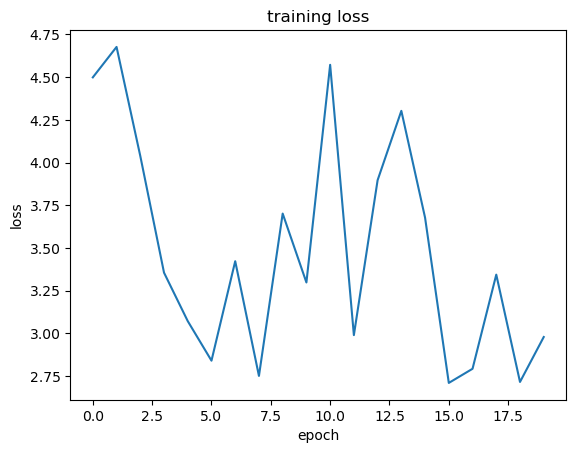

In [27]:
import matplotlib.pyplot as plt

def plot_training_loss(df):
    plt.plot(df['training_loss'])
    plt.title('training loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

if ftm_training_is_finished:
    df = get_training_results_df(ftm_id)
    print(df.head())
    plot_training_loss(df)

# -- Test prompts --

In [29]:
def get_gpt_response_text(prompt, ftm_name_, printit=False): 

    # prompt += "\n\n###\n\n"

    if printit:
        print(f"creating call from {ftm_name_} with prompt: {prompt}")

    response = openai.Completion.create(
        model=ftm_name_,
        # engine="text-davinci-002", 
        prompt=prompt,
        temperature=0.9,
        max_tokens=500,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0.6,
        stop=[" END"]
    )

    return response['choices'][0]['text']

# davinci:ft-sandbox:gpt-ml-qa-pairs-b-2022-11-20-09-29-25

### --- Run with the current model ---      

--> Loads the model again from `ftm_id`

Why? Only after it has trained will it have a `name`, which is needed to send as the `model` param to the OpenAI Completion endpoint

In [30]:
ftm = get_ftm_from_id(ftm_id)
ftm_name = ftm['fine_tuned_model']
ftm_status = ftm['status']

print (f"###\n{ftm_name} \nstatus: {ftm_status}\n###\n")

###
davinci:ft-sandbox:prompt-enhancement-image-generation-2022-12-17-15-57-11 
status: succeeded
###



##### Run a single test prompt 

In [31]:
prompt = "What is the difference between a neural network and a deep learning model?" 
#ftm_name is defined after creating the ftm
print(get_gpt_response_text(prompt, ftm_name, printit=True))

creating call from davinci:ft-sandbox:prompt-enhancement-image-generation-2022-12-17-15-57-11 with prompt: What is the difference between a neural network and a deep learning model?
 The neural network is a popular technique from machine learning that was first used to solve pattern recognition problems. The technique is based on a simple processing model which emphasizes the importance of processing layers to solve data problems. Machine learning refers to this approach as supervised, unsupervised and reinforcement learning. Supervised learning is a straightforward pan of machine learning where the problem is to predict well-defined values of unobserved response variables or supervised learning tasks or to identify spatial or temporal dependencies in a set of variables or inputs. Deep learning is an advanced form of machine learning which relies on training deep, multi-layered artificial neural networks that learn to represent the hierarchical structure of objects and ideas in data th

##### Run a battery of test prompts on the model from "test-prompts.txt"

In [32]:

# save all the question, answer pairs to a csv

import csv



with open(test_prompts_path, 'r') as f:
    lines = f.readlines()
    with open(f"test-outputs/{this_model_name}-gpt-completions-to-test-prompts.csv", 'w',newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['prompt','completion'])
        for i, line in enumerate(lines):
            print(f'Question {i}: {line}')
            answer = get_gpt_response_text(line, ftm_name)
            print(f'Answer {i}: {answer} \n\n\n')
            writer.writerow([line, answer])

Question 0: a circuit board with moss growing on it 

Answer 0: 
IMAGE 


 



Question 1: a group of warlocks caravaning the desert

Answer 1: 
evolving squirrely laughter from the shrilly whirling winds of the desert

evolving to a life of parasitic symbiosis endemic to the desert

faintly starlight glistening on metal chains littered with old bones

fanciful architecture built from chiseled sandstone

factories pumped steam from their chimneys

fallen temples toppled like sand dunes against the red dunes

false belief that the travel's costs would be offset by fees paid for naming the land after oneself

fantastical legends composed around the cursed land

far more leisurely pace than most places of commerce

fatally poisoned in your sleep amongst the sand dunes by cloaked assassins while you dreamed of black-sailed galleons rocking in stormy seas

feet bound in rags of cloth, shuffling through the sand

ferocious sandstorms scouring the land in varying patterns throughout the year


# -- Gather Training results --


In [33]:
# 

def gather_training_results(ftm_trained):
    """ 
    INPUT: finetuned model id
    - calls get_training_results_obj to download results object
    - converts results object to csv and to df 
    OUTPUT:
    results 
    - results obj
    - results df
    - results csv path
    losses
    - train loss
    - token loss
    - valid loss
    plots
    - train, token, valid
    
    """
    # call the previous function 
    results_file_content = get_training_results_obj(ftm_trained)
    # Will also want a CSV file of the results
    # os path join a b 

    filepath = os.path.join(tests_dir_path, f"training-results-{ftm_trained}_results.csv")
    with open(filepath, 'wb') as f:
        f.write(results_file_content)
    # create df
    df = pd.DataFrame(results_file_content)
    return df


# -- Hyperparameter Exploration --


In [34]:

# HYPERPARAMETER EXPLORATION 

EXPLORE_HYPERPARAMS=False

# create a set of various hyperparameters to iterate through
# create a ftmodel for each one 
# save the ftmodel id to a list
# then iterate through the list and generate responses to the test-prompts for each one
# save the responses to a list
# then compare the responses to the test answers
import time 

# wrap this in tqdm to show progress
from tqdm import tqdm 

# load a previous ftm to test 
currsuffix = "curie:ft-personal-2022-11-20-08-38-46"

def create_ftm_suffix(base,**kwargs):
    str = base + ":" + "_".join([f"{k}-{v}, " for k,v in kwargs.items()])
    return str

def already_exists_ftm(suffix):
    all_ft_models = openai.FineTune.list()['data']

    # this checks if the current name is already in the list of ft models
    # any( ) returns True if any element in the list is True
    exists = any([True for i in all_ft_models if suffix in i['fine_tuned_model']])
    print('ftmodel already exists: ', suffix)
    return exists
 

test_file = "gpt-qa-train-formatted_prepared.jsonl"

base_suffix="qa-train-iterate"
# create a set of various hyperparameters to iterate through
# epochs=[1,2,3,4]
# learning_rate_multiplier=[0.1, 0.05, 0.01, 0.005, 0.001]
epochs=[1,2]
learning_rate_multiplier=[0.1, 0.05, 0.01]

suffixes=['A', 'B', 'C', 'D', 'E']

ftmodels=pd.DataFrame(columns=['id', 'epochs', 'learning_rate_multiplier', 'suffix'])

ftmodelcompletions = pd.DataFrame(columns=['id', 'ftm_name', 'epochs', 'learning_rate_multiplier', 'suffix', 'prompt','completion'])

# create a ftmodel for each one

def explore_hyperparams(input_file, ftm, epochs, learning_rate_multiplier, suffixes):

    ## Explore over: 
    # epochs
    # learning rate multiplier


    for epoch in tqdm(epochs):
        for lrm in tqdm(learning_rate_multiplier):

            #######
            # Create a model with the current hyperparameters

            curr_suffix = create_ftm_suffix(base_suffix,lrm=lrm, epoch=epoch)
            # create a ft model with these parameters 
            ftm = file_to_finetuned_model(
                train_file=input_file,
                suffix=curr_suffix,
                n_epochs=epoch,
                learning_rate_multiplier=lrm
            )

            ftm_id = ftm['id']
            print(f"\n\n== Initiated ftm: == \n ftm_id: {ftm_id}. \n Now we wait for the model to train... \n")

            # wait for the ft model to finish training
            current_ft_model_is_ready = await_ft_ready(ftm_id)
            if not current_ft_model_is_ready: 
                print(f"finetuned model timed out: {ftm_id}")
                continue

            ftm = openai.FineTune.retrieve(ftm_id) # need to retrieve the fresh version with its name! 
            ftm_name = ftm['fine_tuned_model']
            print (f"{ftm_id} finetuned model is now ready for testing. \nIts name is: {ftm_name}\n")

            # append this model to the df 
            ftmodels = ftmodels.append({'id': ftm_id, 'ftm_name': ftm_name, 'epochs': epoch, 'learning_rate_multiplier': lrm, 'suffix': curr_suffix}, ignore_index=True)

            ##### 
            # now test every prompt with every ftmodel
            with open ('test-prompts.txt') as f:
                print(f"starting test-prompts on finetuned model {ftm_id}")
                prompts = f.readlines()
                for prompt in tqdm(prompts):
                    # get the completion for this prompt
                    completion = get_gpt_response_text(prompt, ftm_name, printit=True)
                    # append this completion to the df
                    ftmodelcompletions = ftmodelcompletions.append(
                        {'id': ftm_id, 
                        'ftm_name': ftm_name,
                        'epochs': epoch, 
                        'learning_rate_multiplier': lrm, 
                        'suffix': curr_suffix, 
                        'prompt': prompt, 
                        'completion': completion}, 
                        ignore_index=True)
                print('\n\n\nCompleted test prompts for ftmodel: ', ftm_id)

    ftmodels.to_csv('ftmodels.csv')
    ftmodelcompletions.to_csv('ftmodelcompletions.csv')

    print(ftmodels.head())
    print(ftmodelcompletions.head())


if EXPLORE_HYPERPARAMS: 
    explore_hyperparams(formatted_pc_jsonl_path, ftm)

    # SUCCESS! 
    print(ftmodels.head())
    print(ftmodelcompletions.head())

# -- Analyze results --



In [35]:
myftm = get_ftm_from_id(ftm_id)
myftm



<FineTune fine-tune id=ft-ZIsm52M8w9rAS4RAfxcS2FmM at 0x7f8569b0a430> JSON: {
  "created_at": 1671292497,
  "events": [
    {
      "created_at": 1671292497,
      "level": "info",
      "message": "Created fine-tune: ft-ZIsm52M8w9rAS4RAfxcS2FmM",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1671292505,
      "level": "info",
      "message": "Fine-tune costs $0.03",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1671292506,
      "level": "info",
      "message": "Fine-tune enqueued. Queue number: 0",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1671292508,
      "level": "info",
      "message": "Fine-tune started",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1671292592,
      "level": "info",
      "message": "Completed epoch 1/2",
      "object": "fine-tune-event"
    },
    {
      "created_at": 1671292595,
      "level": "info",
      "message": "Completed epoch 2/2",
      "object": "fine-tune

In [36]:
# Export model info as JSON 
import json
with open(f"models/{this_model_name}-{ftm_id}.json", 'w') as f:
    json.dump(myftm, f)

In [37]:
# ensure that the .env file is loaded so it loads the API key as an environment variable 
from dotenv import load_dotenv
load_dotenv()

# assert there is a REPLICATE_API_TOKEN
import os
assert os.getenv('REPLICATE_API_TOKEN') is not None


In [38]:
import replicate
model = replicate.models.get("stability-ai/stable-diffusion")
version = model.versions.get("6359a0cab3ca6e4d3320c33d79096161208e9024d174b2311e5a21b6c7e1131c")


In [39]:
# # TEST 
# # display the image at the URL in the output
# output = version.predict(prompt="a photo of an astronaut riding a horse on mars")
# from IPython.display import Image
# Image(url=output[0])

In [40]:

def get_replicate_image(prompt):
    return version.predict(prompt=prompt)

In [41]:
prepended_image_caption_enhancement_prompt = """You will be shown a series of captions for images. Please write augmented, expanded, enhanced versions of the captions, that describe more detail the types of vibes, illustration, lighting, photography, historical era, textures, listings on artstation, and other properties that might be relevant based on the original prompt. 
Please answer with this format: 

Original: {Original Caption}
Expanded: {Expanded Caption}

Examples: 

Original: """

In [44]:
# """
# For each phrase in the test_prompts_path, 
# then use the ftm to get the expanded phrase 
# get use replicate to get the image for the phrase, 
# then use replicate to get the image for the expanded phrase 
# """

# import replicate
# import os
# from dotenv import load_dotenv

# original_prompts_imgs = {}
# expanded_prompts_imgs = {}

# with open (test_prompts_path) as f:
#     prompts = f.readlines()

#     for prompt in prompts: 
        
#         original_prompts_imgs[prompt]=get_replicate_image(prompt)

#         expanded_prompt = get_gpt_response_text(prepended_image_caption_enhancement_prompt+prompt, ftm_name, printit=False)
#         #remove the first instance of the word "Expanded: " from the beginning of the expanded prompt
#         expanded_prompt = expanded_prompt.replace("Expanded: ", "", 1)
#         expanded_prompts_imgs[expanded_prompt]=get_replicate_image(expanded_prompt)

#         print(f"== Original prompt: {prompt}")
#         print(f"== Expanded prompt: {expanded_prompt}")

#         # print(f"original prompt image: {original_prompts_imgs[-1]}")
#         # print(f"expanded prompt image: {expanded_prompts_imgs[-1]}")
        



In [45]:
import replicate
import os
from dotenv import load_dotenv

from PIL import Image

prompts_images_df = pd.DataFrame(columns=['original_prompt', 'original_image', 'expanded_prompt', 'image'])

with open (test_prompts_path) as f: 
    prompts = f.readlines()
    for prompt in prompts: 
        print (f"Original prompt: {prompt}")

        ##### Get image for original prompt from Replicate 
        original_image = get_replicate_image(prompt)
        # display it 
        i = Image(url=original_image[0])
        i.width = 200
        display(i)

        ##### Get expanded prompt from GPT 
        expanded_prompt = get_gpt_response_text(prepended_image_caption_enhancement_prompt+prompt, ftm_name, printit=False)
        #remove the first instance of the word "Expanded: " from the beginning of the expanded prompt
        expanded_prompt = expanded_prompt.replace("Expanded: ", "", 1)
        print (f"Expanded prompt: {expanded_prompt}")

        ##### Get image for expanded prompt from Replicate
        expanded_image = get_replicate_image(expanded_prompt)
        # display it
        i = Image(url=expanded_image[0])
        i.width = 200
        display(i)

        # append all to the dataframe
        prompts_images_df = prompts_images_df.append(
            {'original_prompt': prompt, 'original_image': original_image, 
            'expanded_prompt': expanded_prompt, 'image': expanded_image}, 
            ignore_index=True)



Original prompt: a circuit board with moss growing on it 



TypeError: 'module' object is not callable

In [50]:
import requests

thang = get_replicate_image("yoyoyoyo")
# display it 
print(type(thang))
print(type(thang[0]))
print(type(Image))



<class 'list'>
<class 'str'>
<class 'module'>


ValueError: embedded null byte

In [58]:
from PIL import Image
from io import BytesIO
def get_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img




In [ ]:
# now make a a grid with two columns, where each row has the original prompt above the original image, and the expanded prompt above the expanded image

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# get the number of rows and columns 
nrows = len(prompts_images_df)
ncols = 2

# create a figure and axes
fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))

# set the spacing between subplots
fig.subplots_adjust(hspace = .5, wspace=.001)

# set the title of the figure
fig.suptitle('Original and Expanded Prompts and Images', fontsize=16)

# iterate through the rows of the dataframe
for i, row in prompts_images_df.iterrows():

    # get the original prompt and image
    # word wrap the text of the prompt inside of the column 

    original_prompt = row['original_prompt']
    original_image = row['original_imgage']

    #word warp 
    original_prompt = '\n'.join(wrap(original_prompt, 50))



    


    # get the expanded prompt and image
    expanded_prompt = row['expanded_prompt']
    expanded_image = row['image']

    # word wrap the text of the prompt inside of the column
    expanded_prompt = '\n'.join(wrap(expanded_prompt, 50))

    # display the original prompt and image
    axs[i, 0].set_title(original_prompt)
    axs[i, 0].imshow(mpimg.imread(original_image[0]))

    # display the expanded prompt and image
    axs[i, 1].set_title(expanded_prompt)
    axs[i, 1].imshow(mpimg.imread(expanded_image[0]))

# hide the x and y ticks
for ax in axs.flat:
    ax.set_xticks([])
    ax.set_yticks([])

# display the figure
plt.show()



In [ ]:
# go through the df and display each pair of original prompt, original image, expanded prompt, expanded image
from PIL import Image

import requests


save_image_dir = "images"


for index, row in prompts_images_df.iterrows():
    print (f"Original Prompt: {row['original_prompt']}")

    # download hte image from a url and save it 

    # get the url of the image
    original_url = row['original_imgage'][0]

    # download the image from the url 
    

    img_data = requests.get(url).content
    filename=f"{index}_original.png"
    filepath = os.path.join(save_image_dir, filename)

    # save as a PIL image 


    print(type(row['original_imgage']))
    print(row['original_imgage'][0])
    i = Image(url=row['original_imgage'][0])
    print (type(i))
    i.save(filename=filepath)

    # save the image to a file

    # os join save_image_dir and the filename
    expanded_url = row['image'][0]
    img_data = requests.get(url).content
    filename=f"{index}_expanded.png"
    filepath = os.path.join(save_image_dir, filename)

    i = Image(url=row['image'][0])
    i.save(filename=filepath)

    # with open(filepath, 'wb') as handler:
    #     handler.write(img_data)
        # why does this throw an error?
        # i.save(filename=filepath)

    # # save the Image object as an image file
    # i.save(filename=filepath)

    # i.width = 400
    # display(i)

    print (f"Expanded Prompt: {row['expanded_prompt']}")
    # # save the image to a file
    # filename=f"exp_prompt{index}_{row['expanded_prompt']}.png"
    # filepath = os.path.join(save_image_dir, filename)
    # # i.save(filename=filepath)


    # i = Image(url=row['image'][0])
    # i.width = 400
    # display(i)

    print ("============================")

In [ ]:
# save both dicts to a csv 
import csv

def save_dict_to_csv(d, filename):
    with open(filename, 'w') as f:
        w = csv.DictWriter(f, d.keys())
        w.writeheader()
        w.writerow(d)

# get datetimestamp to the minute
import datetime
now = datetime.datetime.now().strftime("%Y%m%d-%H%M")

save_dict_to_csv(original_prompts_imgs, f"outputs/original_prompts_imgs{now}.csv")
save_dict_to_csv(expanded_prompts_imgs, f"outputs/expanded_prompts_imgs{now}.csv")